<a href="https://colab.research.google.com/github/extfatkur/gender-classification-based-on-face-recognition-ext/blob/main/project_1_gender_classification_using_vgg16_vgg19_ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf sample_data

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [3]:
import os
import cv2
import gdown
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras_tuner as kt
from keras.models import Model
from keras.models import Sequential, load_model
from keras.applications import VGG16
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import image_dataset_from_directory
from keras.layers import Input, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

## Downloading Datasets

### Folder Images

In [4]:
#!pip install gdown
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [5]:
!gdown https://sci-sba.id/shared/Bootcamp_CV/Dataset_Project1/Dataset.zip

Downloading...
From: https://sci-sba.id/shared/Bootcamp_CV/Dataset_Project1/Dataset.zip
To: /content/Dataset.zip
100% 287M/287M [00:25<00:00, 11.1MB/s]


In [6]:
!unzip /content/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/158373.jpg       
  inflating: Images/165406.jpg       
  inflating: Images/157680.jpg       
  inflating: Images/164933.jpg       
  inflating: Images/158335.jpg       
  inflating: Images/157629.jpg       
  inflating: Images/165764.jpg       
  inflating: Images/164266.jpg       
  inflating: Images/164417.jpg       
  inflating: Images/164726.jpg       
  inflating: Images/157866.jpg       
  inflating: Images/157799.jpg       
  inflating: Images/159493.jpg       
  inflating: Images/164590.jpg       
  inflating: Images/164527.jpg       
  inflating: Images/165009.jpg       
  inflating: Images/189938.jpg       
  inflating: Images/190028.jpg       
  inflating: Images/158747.jpg       
  inflating: Images/164361.jpg       
  inflating: Images/164697.jpg       
  inflating: Images/163944.jpg       
  inflating: Images/159454.jpg       
  inflating: Images/158608.jpg       
  inflating: Images/189971.jpg       

In [7]:
#hapus file Dataset.zip
#!rm -rf Dataset.zip

### List Attribute

In [8]:
list_attribute_url = 'https://sci-sba.id/shared/Bootcamp_CV/Dataset_Project1/list_attr_celeba.txt'
gdown.download(list_attribute_url, fuzzy=True)

Downloading...
From: https://sci-sba.id/shared/Bootcamp_CV/Dataset_Project1/list_attr_celeba.txt
To: /content/list_attr_celeba.txt
26.7MB [00:01, 19.5MB/s]


'list_attr_celeba.txt'

## Splitting Dataset

In [9]:
attribute_list_df = pd.read_csv('list_attr_celeba.txt', sep='\s+', skiprows=1, usecols=['Male'])
attribute_list_df.index.name = 'filename'
attribute_list_df.replace(to_replace=-1, value=0, inplace=True)
attribute_list_df.rename(columns={"Male": "Gender"}, inplace=True)
attribute_list_df

,Gender
filename,
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,0
202596.jpg,1
202597.jpg,1


In [10]:
attribute_list_df.reset_index(drop=False, inplace=True)

In [11]:
attribute_list_df

,filename,Gender
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,0
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,0


In [12]:
images_folder = os.listdir('Images')
attribute_list_df['isExist'] = attribute_list_df['filename'].isin(images_folder)
attribute_list_df

,filename,Gender,isExist
0,000001.jpg,0,False
1,000002.jpg,0,False
2,000003.jpg,1,False
3,000004.jpg,0,False
4,000005.jpg,0,False
...,...,...,...
202594,202595.jpg,0,False
202595,202596.jpg,1,False
202596,202597.jpg,1,False
202597,202598.jpg,0,False


In [13]:
attribute_list_df.drop(attribute_list_df[attribute_list_df['isExist'] == False].index, inplace=True)
attribute_list_df

,filename,Gender,isExist
50,000051.jpg,1,True
51,000052.jpg,1,True
64,000065.jpg,1,True
165,000166.jpg,1,True
197,000198.jpg,0,True
...,...,...,...
202319,202320.jpg,0,True
202339,202340.jpg,0,True
202346,202347.jpg,0,True
202356,202357.jpg,0,True


In [14]:
attribute_list_df.reset_index(drop=True, inplace=True)
attribute_list_df

,filename,Gender,isExist
0,000051.jpg,1,True
1,000052.jpg,1,True
2,000065.jpg,1,True
3,000166.jpg,1,True
4,000198.jpg,0,True
...,...,...,...
4995,202320.jpg,0,True
4996,202340.jpg,0,True
4997,202347.jpg,0,True
4998,202357.jpg,0,True


In [15]:
#buat folder Splitted
!mkdir Splitted

#buat subfolder Test
!mkdir Splitted/Test

#buat subfolder Train
!mkdir Splitted/Train

#buat subfolder Validation
!mkdir Splitted/Validation

In [16]:
images_path = 'Images'
splitted_folder = 'Splitted'
train_folder = os.path.join(splitted_folder, 'Train')
validation_folder = os.path.join(splitted_folder, 'Validation')
test_folder = os.path.join(splitted_folder, 'Test')

In [17]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [18]:
for index, row in attribute_list_df.iterrows():
    filename = row['filename']
    gender_label = row['Gender']

    if index % 10 < 8:
        splitted_folder = train_folder
    elif index % 10 == 8:
        splitted_folder = validation_folder
    else:
        splitted_folder = test_folder

    if gender_label == 0:
        gender_folder = os.path.join(splitted_folder, 'Female')
    else:
        gender_folder = os.path.join(splitted_folder, 'Male')

    os.makedirs(gender_folder, exist_ok=True)

    source_path = os.path.join(images_path, filename)
    destination_path = os.path.join(gender_folder, filename)

    if not os.path.exists(destination_path):
        print(f'Copying file {source_path} to {gender_folder}')
        shutil.copy(source_path, destination_path)
    else:
        print(f'Skipping file {filename} in {gender_folder} as it already exists.')

print('Splitting Datasets completed')

Streaming output truncated to the last 5000 lines.
Copying file Images/000052.jpg to Splitted/Train/Male
Copying file Images/000065.jpg to Splitted/Train/Male
Copying file Images/000166.jpg to Splitted/Train/Male
Copying file Images/000198.jpg to Splitted/Train/Female
Copying file Images/000201.jpg to Splitted/Train/Female
Copying file Images/000240.jpg to Splitted/Train/Female
Copying file Images/000282.jpg to Splitted/Train/Male
Copying file Images/000352.jpg to Splitted/Validation/Male
Copying file Images/000409.jpg to Splitted/Test/Male
Copying file Images/000414.jpg to Splitted/Train/Male
Copying file Images/000439.jpg to Splitted/Train/Male
Copying file Images/000444.jpg to Splitted/Train/Male
Copying file Images/000474.jpg to Splitted/Train/Male
Copying file Images/000525.jpg to Splitted/Train/Female
Copying file Images/000545.jpg to Splitted/Train/Male
Copying file Images/000559.jpg to Splitted/Train/Male
Copying file Images/000572.jpg to Splitted/Train/Male
Copying file Images

## Preprocessing

In [19]:
image_size = (120, 120)
batch_size = 32

### Train Datasets

In [20]:
train_datasets = image_dataset_from_directory(
    directory=train_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(train_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 4000 files belonging to 2 classes.


In [21]:
train_data_batches = [(data.numpy(), labels.numpy()) for data, labels in train_datasets]
train_data, train_labels = zip(*train_data_batches)
train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

### Validation Datasets

In [22]:
validation_datasets = image_dataset_from_directory(
    directory=validation_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(validation_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 500 files belonging to 2 classes.


In [23]:
validation_data_batches = [(data.numpy(), labels.numpy()) for data, labels in validation_datasets]
validation_data, validation_labels = zip(*validation_data_batches)
validation_data = np.vstack(validation_data)
validation_labels = np.hstack(validation_labels)

### Test Datasets

In [24]:
test_datasets = image_dataset_from_directory(
    directory=test_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(test_folder),
    image_size=image_size,
    batch_size=batch_size
)

Found 500 files belonging to 2 classes.


In [25]:
test_data_batches = [(data.numpy(), labels.numpy()) for data, labels in test_datasets]
test_data, test_labels = zip(*test_data_batches)
test_data = np.vstack(test_data)
test_labels = np.hstack(test_labels)

## VGG16 - Build Model

In [26]:
epochs = 100
hp_opz = ['hyperband', 'RandomSearch', 'BayesianOptimization']

In [27]:
def build_vgg(hp):
    vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(120, 120, 3)))
    vgg.trainable = False

    model = Sequential()

    for vgg_layer in vgg.layers:
        model.add(vgg_layer)

    model.add(Flatten())

    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)
    for i in range(num_hidden_layers):
        num_units = hp.Choice(f'num_units_{i}', values=[8, 16, 32, 64])
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.9, step=0.1)

        if i == 0:
            model.add(Dense(num_units, activation='relu'))
        else:
            model.add(Dense(num_units, activation='relu'))
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop', 'SGD'])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    if optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    if optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

### VGG16 (Tuning) Hyperband

In [28]:
hyperband_tuner = kt.Hyperband(
    build_vgg,
    objective='val_accuracy',
    max_epochs=epochs,
    factor=3,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[0])
)

58889256/58889256 [==============================] - 2s 0us/step


In [29]:
best_hyperband_param = {}
hyperband_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

hyperband_results = hyperband_tuner.results_summary()

Trial 254 Complete [00h 02m 53s]
val_accuracy: 0.9079999923706055

Best val_accuracy So Far: 0.9160000085830688
Total elapsed time: 01h 26m 39s
Results summary
Results in tuner/hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0147 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 8
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.01
num_units_1: 32
dropout_rate_1: 0.5
num_units_2: 64
dropout_rate_2: 0.2
num_units_3: 32
dropout_rate_3: 0.5
num_units_4: 64
dropout_rate_4: 0.4
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.9160000085830688

Trial 0203 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 32
dropout_rate_0: 0.4
optimizer: RMSprop
learning_rate: 0.001
num_units_1: 8
dropout_rate_1: 0.8
num_units_2: 64
dropout_rate_2: 0.9
num_units_3: 64
dropout_rate_3: 0.4
num_units_4: 64
dropout_rate_4: 0.1
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2

In [30]:
best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG16-with-{}-Optimization.h5'.format(hp_opz[0]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
best_hyperband_model = best_hyperband_model.fit(train_datasets, validation_data=(test_datasets), epochs=epochs,
                                                batch_size=batch_size, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
121/125 [============================>.] - ETA: 0s - loss: 0.9810 - accuracy: 0.5857
Epoch 1: val_loss improved from inf to 0.68223, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 3s 15ms/step - loss: 0.9715 - accuracy: 0.5857 - val_loss: 0.6822 - val_accuracy: 0.5940
Epoch 2/100
  1/125 [..............................] - ETA: 5s - loss: 0.6789 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/125 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5907
Epoch 2: val_loss improved from 0.68223 to 0.67940, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.6824 - accuracy: 0.5880 - val_loss: 0.6794 - val_accuracy: 0.5920
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.6796 - accuracy: 0.5863
Epoch 3: val_loss improved from 0.67940 to 0.67766, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.6792 - accuracy: 0.5880 - val_loss: 0.6777 - val_accuracy: 0.5920
Epoch 4/100
121/125 [============================>.] - ETA: 0s - loss: 0.6788 - accuracy: 0.5891
Epoch 4: val_loss improved from 0.67766 to 0.67596, saving model to VGG16-with-hyperband-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.6788 - accuracy: 0.5890 - val_loss: 0.6760 - val_accuracy: 0.5940
Epoch 5/10

### VGG16 (Tuning) RandomSearch

In [31]:
randomsearch_tuner = kt.RandomSearch(
    build_vgg,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=1,
    directory='tuner',
    project_name=str(hp_opz[1])
)

In [32]:
best_randomsearch_param = {}
randomsearch_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

randomsearch_results = randomsearch_tuner.results_summary()

Trial 10 Complete [00h 03m 00s]
val_accuracy: 0.6679999828338623

Best val_accuracy So Far: 0.9160000085830688
Total elapsed time: 00h 28m 24s
Results summary
Results in tuner/RandomSearch
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 64
dropout_rate_0: 0.30000000000000004
optimizer: Adam
learning_rate: 0.001
num_units_1: 64
dropout_rate_1: 0.5
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 64
dropout_rate_3: 0.2
Score: 0.9160000085830688

Trial 01 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 32
dropout_rate_0: 0.1
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 64
dropout_rate_1: 0.6
num_units_2: 64
dropout_rate_2: 0.1
num_units_3: 64
dropout_rate_3: 0.1
Score: 0.9020000100135803

Trial 07 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 8
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.0001
num_units_1: 32
dropout_rate_1: 0.9
num_units_2: 32
dropout_rate_2

In [33]:
best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG16-with-{}-Optimization.h5'.format(hp_opz[1]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
best_randomsearch_model = best_randomsearch_model.fit(train_datasets, validation_data=(test_datasets), epochs=100,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 1.3210 - accuracy: 0.5650
Epoch 1: val_loss improved from inf to 0.62433, saving model to VGG16-with-RandomSearch-Optimization.h5
125/125 [==============================] - 4s 16ms/step - loss: 1.3210 - accuracy: 0.5650 - val_loss: 0.6243 - val_accuracy: 0.6380
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.6012
Epoch 2: val_loss improved from 0.62433 to 0.53881, saving model to VGG16-with-RandomSearch-Optimization.h5
125/125 [==============================] - 2s 15ms/step - loss: 0.7128 - accuracy: 0.6012 - val_loss: 0.5388 - val_accuracy: 0.6660
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.6383 - accuracy: 0.6219
Epoch 3: val_loss improved from 0.53881 to 0.47123, saving model to VGG16-with-RandomSearch-Optimization.h5
125/125 [==============================] - 2s 15ms/step - loss: 0.6398 - accuracy: 0.6198 - val_loss: 0.4712 - val_accuracy: 

### VGG16 (Tuning) Bayesian Optimization

In [34]:
bayesian_tuner = kt.BayesianOptimization(
    build_vgg,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[2])
)

In [35]:
best_bayesian_param = {}
bayesian_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

bayesian_results = bayesian_tuner.results_summary()

Trial 10 Complete [00h 02m 57s]
val_accuracy: 0.6240000128746033

Best val_accuracy So Far: 0.9039999842643738
Total elapsed time: 00h 28m 15s
Results summary
Results in tuner/BayesianOptimization
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 32
dropout_rate_0: 0.1
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 64
dropout_rate_1: 0.6
num_units_2: 64
dropout_rate_2: 0.1
num_units_3: 64
dropout_rate_3: 0.1
Score: 0.9039999842643738

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 64
dropout_rate_0: 0.30000000000000004
optimizer: Adam
learning_rate: 0.001
num_units_1: 64
dropout_rate_1: 0.5
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 64
dropout_rate_3: 0.2
Score: 0.8999999761581421

Trial 07 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 8
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.0001
num_units_1: 32
dropout_rate_1: 0.9
num_units_2: 32
dropou

In [36]:
best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG16-with-{}-Optimization.h5'.format(hp_opz[2]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
best_bayesian_model = best_bayesian_model.fit(train_datasets, validation_data=(test_datasets), epochs=100,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 1.8260 - accuracy: 0.6670
Epoch 1: val_loss improved from inf to 0.54027, saving model to VGG16-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 3s 16ms/step - loss: 1.8260 - accuracy: 0.6670 - val_loss: 0.5403 - val_accuracy: 0.8120
Epoch 2/100
121/125 [============================>.] - ETA: 0s - loss: 0.7978 - accuracy: 0.7510
Epoch 2: val_loss improved from 0.54027 to 0.46031, saving model to VGG16-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.7901 - accuracy: 0.7525 - val_loss: 0.4603 - val_accuracy: 0.8400
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.5675 - accuracy: 0.7952
Epoch 3: val_loss improved from 0.46031 to 0.40301, saving model to VGG16-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.5657 - accuracy: 0.7958 - val_loss:

### VGG16 (Evaluation) Hyperband

In [37]:
vgg16_hyperband = load_model('VGG16-with-hyperband-Optimization.h5')

loss, accuracy = vgg16_hyperband.evaluate(test_datasets)
print(f'VGG16 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 0s 10ms/step - loss: 0.6736 - accuracy: 0.5960
VGG16 with Hyperband Tuning model loss: 0.673625111579895, accuracy: 0.5960000157356262


### VGG16 (Evaluation) RandomSearch

In [38]:
vgg16_randomsearch = load_model('VGG16-with-RandomSearch-Optimization.h5')

loss, accuracy = vgg16_randomsearch.evaluate(test_datasets)
print(f'VGG16 with RandomSearch Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 0s 10ms/step - loss: 0.2685 - accuracy: 0.8820
VGG16 with RandomSearch Tuning model loss: 0.26853957772254944, accuracy: 0.8820000290870667


### VGG16 (Evaluation) Bayesian

In [39]:
vgg16_bayesian = load_model('VGG16-with-BayesianOptimization-Optimization.h5')

loss, accuracy = vgg16_bayesian.evaluate(test_datasets)
print(f'VGG16 with Bayesian Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 0s 10ms/step - loss: 0.3566 - accuracy: 0.8720
VGG16 with Bayesian Tuning model loss: 0.35659193992614746, accuracy: 0.871999979019165


### VGG16 (Confusion Matrix) Hyperband

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.59      1.00      0.75       296
           1       1.00      0.01      0.02       204

    accuracy                           0.60       500
   macro avg       0.80      0.50      0.38       500
weighted avg       0.76      0.60      0.45       500



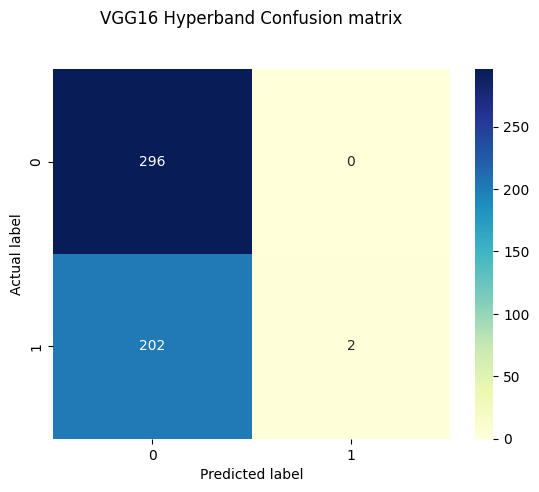

In [40]:
vgg16_hyperband_prediction = vgg16_hyperband.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg16_hyperband_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG16 Hyperband Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg16_hyperband_prediction)))

### VGG16 (Confusion Matrix) RandomSearch

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       296
           1       0.84      0.87      0.86       204

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



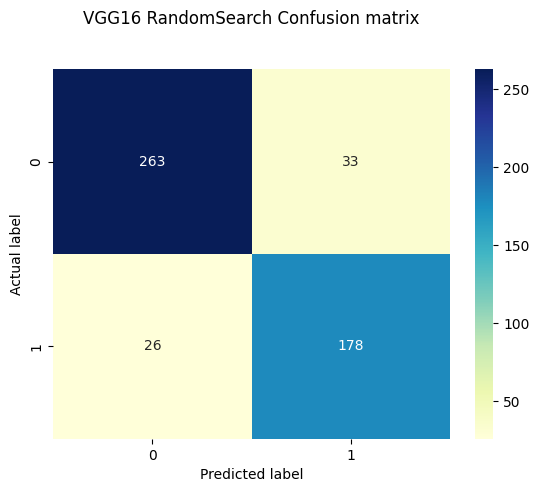

In [41]:
vgg16_randomsearch_prediction = vgg16_randomsearch.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg16_randomsearch_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG16 RandomSearch Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg16_randomsearch_prediction)))

### VGG16 (Confusion Matrix) Bayesian

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       296
           1       0.82      0.87      0.85       204

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



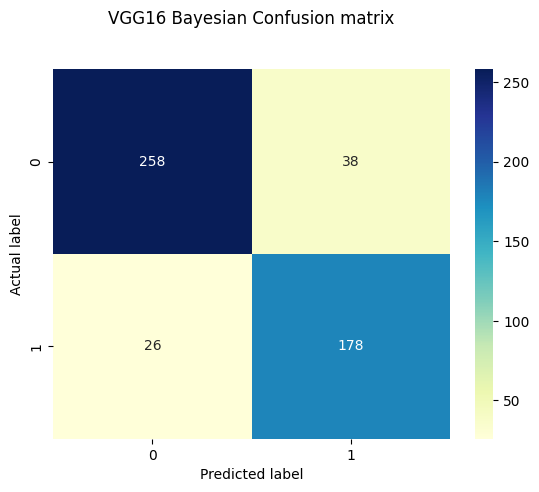

In [42]:
vgg16_bayesian_prediction = vgg16_bayesian.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg16_bayesian_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG16 Bayesian Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg16_bayesian_prediction)))

### VGG16 (Test Prediction) Hyperband

In [43]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for images, labels in test_datasets.take(1):
    predicts = vgg16_hyperband.predict(images)
    for image, predict in zip(images, predicts):
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            if np.round(predict) == 0:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Female', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Female Detected')
                plt.show()
            else:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Male', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Male Detected')
                plt.show()
    break

1/1 [==============================] - 0s 24ms/step


error: OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### VGG16 (Test Prediction) RandomSearch

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for images, labels in test_datasets.take(1):
    predicts = vgg16_randomsearch.predict(images)
    for image, predict in zip(images, predicts):
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            if np.round(predict) == 0:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Female', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Female Detected')
                plt.show()
            else:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Male', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Male Detected')
                plt.show()
    break

### VGG16 (Test Prediction) Bayesian

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for images, labels in test_datasets.take(1):
    predicts = vgg16_bayesian.predict(images)
    for image, predict in zip(images, predicts):
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            if np.round(predict) == 0:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Female', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Female Detected')
                plt.show()
            else:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                # cv2.putText(image, 'Male', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                plt.imshow(image)
                plt.title('Male Detected')
                plt.show()
    break

## VGG19 - Build Model

In [ ]:
read_image = cv2.imread(source_path)
image_size = (read_image.shape[0], read_image.shape[1])
batch_size = 32

In [ ]:
train_datasets = image_dataset_from_directory(
    directory=train_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(train_folder),
    image_size=image_size,
    batch_size=batch_size
)

In [ ]:
train_data_batches = [(data.numpy(), labels.numpy()) for data, labels in train_datasets]
train_data, train_labels = zip(*train_data_batches)
train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

In [ ]:
validation_datasets = image_dataset_from_directory(
    directory=validation_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(validation_folder),
    image_size=image_size,
    batch_size=batch_size
)

In [ ]:
validation_data_batches = [(data.numpy(), labels.numpy()) for data, labels in validation_datasets]
validation_data, validation_labels = zip(*validation_data_batches)
validation_data = np.vstack(validation_data)
validation_labels = np.hstack(validation_labels)

In [ ]:
test_datasets = image_dataset_from_directory(
    directory=test_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(test_folder),
    image_size=image_size,
    batch_size=batch_size
)

In [ ]:
test_data_batches = [(data.numpy(), labels.numpy()) for data, labels in test_datasets]
test_data, test_labels = zip(*test_data_batches)
test_data = np.vstack(test_data)
test_labels = np.hstack(test_labels)

In [ ]:
def build_vgg(hp):
    vgg = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=read_image.shape))
    vgg.trainable = False

    model = Sequential()

    for vgg_layer in vgg.layers:
        model.add(vgg_layer)

    model.add(Flatten())

    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)
    for i in range(num_hidden_layers):
        num_units = hp.Choice(f'num_units_{i}', values=[8, 16, 32, 64])
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.9, step=0.1)

        if i == 0:
            model.add(Dense(num_units, activation='relu'))
        else:
            model.add(Dense(num_units, activation='relu'))
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop', 'SGD'])
    loss_function = hp.Choice('loss_function', values=['binary_crossentropy', 'hinge', 'squared_hinge'])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
        model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

    if optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
        model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

    if optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)
        model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

    return model

### VGG19 (Tuning) Hyperbend

In [44]:
hyperband_tuner = kt.Hyperband(
    build_vgg,
    objective='val_accuracy',
    max_epochs=epochs,
    factor=3,
    seed=42,
    directory='tuner19',
    project_name=str(hp_opz[0] + 'vgg19')
)

In [46]:
best_hyperband_param = {}
hyperband_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

hyperband_results = hyperband_tuner.results_summary()

Trial 254 Complete [00h 02m 54s]
val_accuracy: 0.8999999761581421

Best val_accuracy So Far: 0.9240000247955322
Total elapsed time: 01h 32m 33s
Results summary
Results in tuner19/hyperbandvgg19
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0208 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 64
dropout_rate_0: 0.5
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 32
dropout_rate_1: 0.7000000000000001
num_units_2: 32
dropout_rate_2: 0.1
num_units_3: 16
dropout_rate_3: 0.8
num_units_4: 64
dropout_rate_4: 0.6
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0204
Score: 0.9240000247955322

Trial 0144 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 8
dropout_rate_0: 0.30000000000000004
optimizer: SGD
learning_rate: 0.01
num_units_1: 64
dropout_rate_1: 0.1
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 8
dropout_rate_3: 0.1
num_units_4: 16
dropout_rate_4: 0.9
tuner/epochs: 34
tuner/initial_ep

In [47]:
best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG19-with-{}-Optimization.h5'.format(hp_opz[0]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
best_hyperband_model = best_hyperband_model.fit(train_datasets, validation_data=(test_datasets), epochs=epochs,
                                                batch_size=batch_size, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
121/125 [============================>.] - ETA: 0s - loss: 1.9556 - accuracy: 0.6276
Epoch 1: val_loss improved from inf to 0.55156, saving model to VGG19-with-hyperband-Optimization.h5
125/125 [==============================] - 3s 15ms/step - loss: 1.9162 - accuracy: 0.6310 - val_loss: 0.5516 - val_accuracy: 0.7900
Epoch 2/100
  1/125 [..............................] - ETA: 5s - loss: 1.1457 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/125 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.6911
Epoch 2: val_loss improved from 0.55156 to 0.44661, saving model to VGG19-with-hyperband-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.6847 - accuracy: 0.6935 - val_loss: 0.4466 - val_accuracy: 0.8180
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.5300 - accuracy: 0.7363
Epoch 3: val_loss improved from 0.44661 to 0.43299, saving model to VGG19-with-hyperband-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.5259 - accuracy: 0.7383 - val_loss: 0.4330 - val_accuracy: 0.8380
Epoch 4/100
121/125 [============================>.] - ETA: 0s - loss: 0.4638 - accuracy: 0.7771
Epoch 4: val_loss improved from 0.43299 to 0.41267, saving model to VGG19-with-hyperband-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.4584 - accuracy: 0.7800 - val_loss: 0.4127 - val_accuracy: 0.8500
Epoch 5/10

### VGG19 (Tuning) RandomSearch

In [48]:
randomsearch_tuner = kt.RandomSearch(
    build_vgg,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=1,
    directory='tuner19',
    project_name=str(hp_opz[1] + 'vgg19')
)

In [49]:
best_randomsearch_param = {}
randomsearch_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

randomsearch_results = randomsearch_tuner.results_summary()

Trial 10 Complete [00h 03m 03s]
val_accuracy: 0.6320000290870667

Best val_accuracy So Far: 0.8999999761581421
Total elapsed time: 00h 28m 37s
Results summary
Results in tuner19/RandomSearchvgg19
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 32
dropout_rate_0: 0.1
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 64
dropout_rate_1: 0.6
num_units_2: 64
dropout_rate_2: 0.1
num_units_3: 64
dropout_rate_3: 0.1
Score: 0.8999999761581421

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 64
dropout_rate_0: 0.30000000000000004
optimizer: Adam
learning_rate: 0.001
num_units_1: 64
dropout_rate_1: 0.5
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 64
dropout_rate_3: 0.2
Score: 0.8999999761581421

Trial 07 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 8
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.0001
num_units_1: 32
dropout_rate_1: 0.9
num_units_2: 32
dropout

In [50]:
best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG19-with-{}-Optimization.h5'.format(hp_opz[1]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
best_randomsearch_model = best_randomsearch_model.fit(train_datasets, validation_data=(test_datasets), epochs=100,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
121/125 [============================>.] - ETA: 0s - loss: 1.7873 - accuracy: 0.6565
Epoch 1: val_loss improved from inf to 0.54741, saving model to VGG19-with-RandomSearch-Optimization.h5
125/125 [==============================] - 3s 15ms/step - loss: 1.7515 - accuracy: 0.6610 - val_loss: 0.5474 - val_accuracy: 0.7760
Epoch 2/100
121/125 [============================>.] - ETA: 0s - loss: 0.7574 - accuracy: 0.7262
Epoch 2: val_loss improved from 0.54741 to 0.46997, saving model to VGG19-with-RandomSearch-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.7496 - accuracy: 0.7287 - val_loss: 0.4700 - val_accuracy: 0.7880
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.5555 - accuracy: 0.7624
Epoch 3: val_loss improved from 0.46997 to 0.43982, saving model to VGG19-with-RandomSearch-Optimization.h5
125/125 [==============================] - 2s 14ms/step - loss: 0.5602 - accuracy: 0.7625 - val_loss: 0.4398 - val_accuracy: 

### VGG19 (Tuning) Bayesian Optimization

In [51]:
bayesian_tuner = kt.BayesianOptimization(
    build_vgg,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    directory='tuner19',
    project_name=str(hp_opz[2] + 'vgg19')
)

In [52]:
best_bayesian_param = {}
bayesian_tuner.search(train_datasets, validation_data=(validation_datasets), epochs=epochs, batch_size=batch_size, shuffle=True)

bayesian_results = bayesian_tuner.results_summary()

Trial 10 Complete [00h 02m 58s]
val_accuracy: 0.6399999856948853

Best val_accuracy So Far: 0.9200000166893005
Total elapsed time: 00h 28m 38s
Results summary
Results in tuner19/BayesianOptimizationvgg19
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
num_hidden_layers: 1
num_units_0: 8
dropout_rate_0: 0.9
optimizer: SGD
learning_rate: 0.0001
num_units_1: 32
dropout_rate_1: 0.9
num_units_2: 32
dropout_rate_2: 0.1
num_units_3: 32
dropout_rate_3: 0.1
Score: 0.9200000166893005

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
num_units_0: 64
dropout_rate_0: 0.30000000000000004
optimizer: Adam
learning_rate: 0.001
num_units_1: 64
dropout_rate_1: 0.5
num_units_2: 16
dropout_rate_2: 0.8
num_units_3: 64
dropout_rate_3: 0.2
Score: 0.9179999828338623

Trial 01 summary
Hyperparameters:
num_hidden_layers: 2
num_units_0: 32
dropout_rate_0: 0.1
optimizer: RMSprop
learning_rate: 0.0001
num_units_1: 64
dropout_rate_1: 0.6
num_units_2: 64

In [53]:
best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('VGG19-with-{}-Optimization.h5'.format(hp_opz[2]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
best_bayesian_model = best_bayesian_model.fit(train_datasets, validation_data=(test_datasets), epochs=100,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
121/125 [============================>.] - ETA: 0s - loss: 1.2272 - accuracy: 0.7244
Epoch 1: val_loss improved from inf to 0.61067, saving model to VGG19-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 3s 15ms/step - loss: 1.2096 - accuracy: 0.7247 - val_loss: 0.6107 - val_accuracy: 0.7420
Epoch 2/100
121/125 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.7805
Epoch 2: val_loss improved from 0.61067 to 0.51719, saving model to VGG19-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 2s 13ms/step - loss: 0.5700 - accuracy: 0.7807 - val_loss: 0.5172 - val_accuracy: 0.7960
Epoch 3/100
121/125 [============================>.] - ETA: 0s - loss: 0.4908 - accuracy: 0.8120
Epoch 3: val_loss improved from 0.51719 to 0.48966, saving model to VGG19-with-BayesianOptimization-Optimization.h5
125/125 [==============================] - 2s 13ms/step - loss: 0.4911 - accuracy: 0.8117 - val_loss:

### VGG19 (Evaluation) Hyperband

In [54]:
vgg19_hyperband = load_model('VGG19-with-hyperband-Optimization.h5')

loss, accuracy = vgg16_hyperband.evaluate(test_datasets)
print(f'VGG16 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 0s 10ms/step - loss: 0.6736 - accuracy: 0.5960
VGG16 with Hyperband Tuning model loss: 0.6736250519752502, accuracy: 0.5960000157356262


### VGG19 (Evaluation) RandomSearch

In [55]:
vgg19_randomsearch = load_model('VGG19-with-RandomSearch-Optimization.h5')

loss, accuracy = vgg16_randomsearch.evaluate(test_datasets)
print(f'VGG16 with RandomSearch Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 0s 10ms/step - loss: 0.2685 - accuracy: 0.8820
VGG16 with RandomSearch Tuning model loss: 0.2685392498970032, accuracy: 0.8820000290870667


### VGG19 (Evaluation) Bayesian

In [56]:
vgg19_bayesian = load_model('VGG19-with-BayesianOptimization-Optimization.h5')

loss, accuracy = vgg16_bayesian.evaluate(test_datasets)
print(f'VGG16 with Bayesian Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 0s 10ms/step - loss: 0.3566 - accuracy: 0.8720
VGG16 with Bayesian Tuning model loss: 0.35659363865852356, accuracy: 0.871999979019165


### VGG19 (Confusion Matrix) Hyperband

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       296
           1       0.85      0.86      0.86       204

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



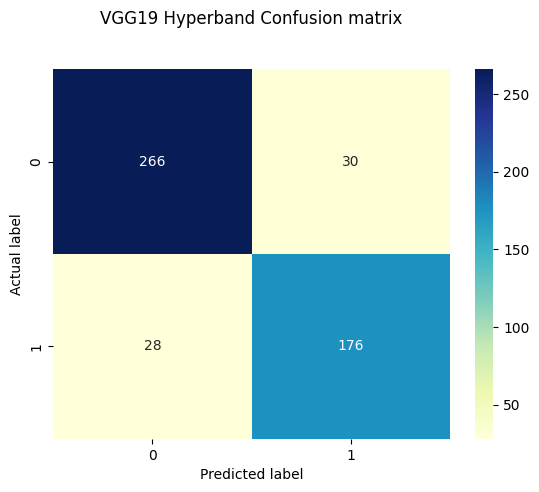

In [57]:
vgg19_hyperband_prediction = vgg19_hyperband.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg19_hyperband_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG19 Hyperband Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg19_hyperband_prediction)))

### VGG19 (Confusion Matrix) RandomSearch

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       296
           1       0.81      0.80      0.81       204

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



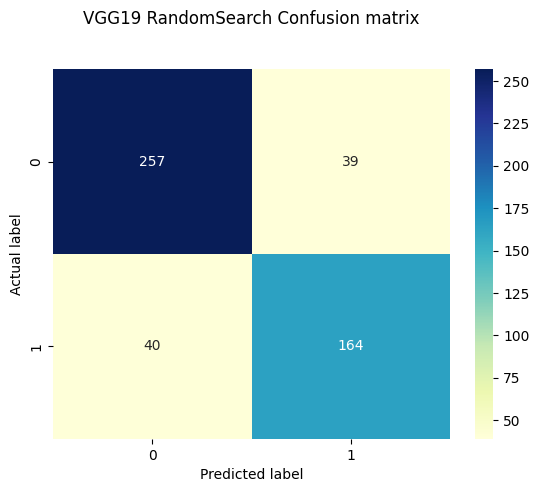

In [58]:
vgg19_randomsearch_prediction = vgg19_randomsearch.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg19_randomsearch_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG19 RandomSearch Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg19_randomsearch_prediction)))

### VGG19 (Confusion Matrix) Bayesian

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       296
           1       0.80      0.89      0.84       204

    accuracy                           0.87       500
   macro avg       0.86      0.87      0.86       500
weighted avg       0.87      0.87      0.87       500



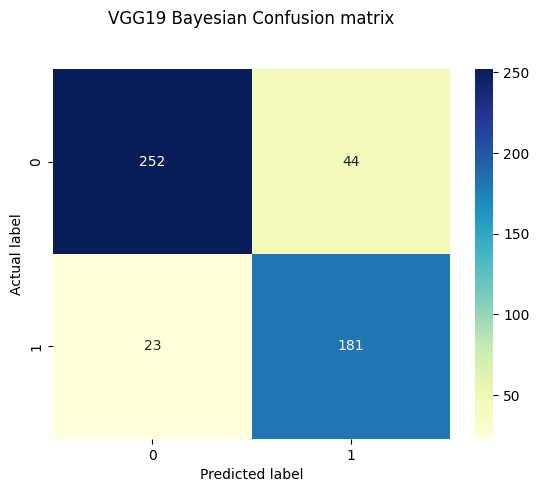

In [59]:
vgg19_bayesian_prediction = vgg19_bayesian.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(vgg19_bayesian_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('VGG19 Bayesian Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(vgg19_bayesian_prediction)))

### VGG19 (Test Prediction) Hyperband

In [60]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for images, labels in test_datasets.take(1):
    predicts = vgg19_hyperband.predict(images)
    for image, predict in zip(images, predicts):
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            if np.round(predict) == 0:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                cv2.putText(image, 'Female', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
                plt.imshow(image)
                plt.title('Gender Detection')
                plt.show()
            else:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                cv2.putText(image, 'Male', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
                plt.imshow(image)
                plt.title('Gender Detection')
                plt.show()
    break

1/1 [==============================] - 0s 26ms/step


error: OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'


### VGG19 (Test Prediction) RandomSearch

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
for images, labels in test_datasets.take(1):
    predicts = vgg19_randomsearch.predict(images)
    for image, predict in zip(images, predicts):
        image = np.array(image, dtype='uint8')
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            if np.round(predict) == 0:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                cv2.putText(image, 'Female', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
                plt.imshow(image)
                plt.title('Gender Detection')
                plt.show()
            else:
                cv2.rectangle(image, (x, y),((x + w), (y + h)), (0, 255, 0), 2)
                cv2.putText(image, 'Male', (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
                plt.imshow(image)
                plt.title('Gender Detection')
                plt.show()
    break

### VGG19 (Test Prediction) Bayesian